# **Polls App: Part 2**

This part begins where part 1 left off. We’ll set up the database, create my first model, and get a quick introduction to Django’s automatically-generated admin site.

# **Database setup**

Now, open up mysite/settings.py. It’s a normal Python module with module-level variables representing Django settings.

By default, the configuration uses SQLite. If you’re new to databases, or you’re just interested in trying Django, this is the easiest choice. SQLite is included in Python, so you won’t need to install anything else to support your database. When starting your first real project, however, you may want to use a more scalable database like PostgreSQL, to avoid database-switching headaches down the road.

If you wish to use another database, install the appropriate database bindings and change the following keys in the DATABASES 'default' item to match your database connection settings:

ENGINE – Either 'django.db.backends.sqlite3', 'django.db.backends.postgresql', 'django.db.backends.mysql', or 'django.db.backends.oracle'. Other backends are also available.
NAME – The name of your database. If you’re using SQLite, the database will be a file on your computer; in that case, NAME should be the full absolute path, including filename, of that file. The default value, BASE_DIR / 'db.sqlite3', will store the file in your project directory.
If you are not using SQLite as your database, additional settings such as USER, PASSWORD, and HOST must be added. For more details, see the reference documentation for DATABASES.

For databases other than SQLite

If you’re using a database besides SQLite, make sure you’ve created a database by this point. Do that with “CREATE DATABASE database_name;” within your database’s interactive prompt.

Also make sure that the database user provided in mysite/settings.py has “create database” privileges. This allows automatic creation of a test database which will be needed in a later tutorial.

If you’re using SQLite, you don’t need to create anything beforehand - the database file will be created automatically when it is needed.

While you’re editing mysite/settings.py, set TIME_ZONE to your time zone.

Also, note the INSTALLED_APPS setting at the top of the file. That holds the names of all Django applications that are activated in this Django instance. Apps can be used in multiple projects, and you can package and distribute them for use by others in their projects.

By default, INSTALLED_APPS contains the following apps, all of which come with Django:

django.contrib.admin – The admin site. You’ll use it shortly.

django.contrib.auth – An authentication system.

django.contrib.contenttypes – A framework for content types.

django.contrib.sessions – A session framework.

django.contrib.messages – A messaging framework.

django.contrib.staticfiles – A framework for managing static files.

These applications are included by default as a convenience for the common case.

Some of these applications make use of at least one database table, though, so we need to create the tables in the database before we can use them. To do that, run the following command:

In [ ]:
...\> py manage.py migrate

The migrate command looks at the INSTALLED_APPS setting and creates any necessary database tables according to the database settings in your mysite/settings.py file and the database migrations shipped with the app (we’ll cover those later). You’ll see a message for each migration it applies. If you’re interested, run the command-line client for your database and type \dt (PostgreSQL), SHOW TABLES; (MariaDB, MySQL), .tables (SQLite), or SELECT TABLE_NAME FROM USER_TABLES; (Oracle) to display the tables Django created.

For the minimalists

Like we said above, the default applications are included for the common case, but not everybody needs them. If you don’t need any or all of them, feel free to comment-out or delete the appropriate line(s) from INSTALLED_APPS before running migrate. The migrate command will only run migrations for apps in INSTALLED_APPS.

# **Creating Models**

Now we’ll define your models – essentially, your database layout, with additional metadata.

Philosophy

A model is the single, definitive source of information about your data. It contains the essential fields and behaviors of the data you’re storing. Django follows the DRY Principle. The goal is to define your data model in one place and automatically derive things from it.

This includes the migrations - unlike in Ruby On Rails, for example, migrations are entirely derived from your models file, and are essentially a history that Django can roll through to update your database schema to match your current models.

In our poll app, we’ll create two models: Question and Choice. A Question has a question and a publication date. A Choice has two fields: the text of the choice and a vote tally. Each Choice is associated with a Question.

These concepts are represented by Python classes. Edit the polls/models.py file so it looks like this:

In [ ]:
from django.db import models


class Question(models.Model):
    question_text = models.CharField(max_length=200)
    pub_date = models.DateTimeField("date published")


class Choice(models.Model):
    question = models.ForeignKey(Question, on_delete=models.CASCADE)
    choice_text = models.CharField(max_length=200)
    votes = models.IntegerField(default=0)

Here, each model is represented by a class that subclasses django.db.models.Model. Each model has a number of class variables, each of which represents a database field in the model.

Each field is represented by an instance of a Field class – e.g., CharField for character fields and DateTimeField for datetimes. This tells Django what type of data each field holds.

The name of each Field instance (e.g. question_text or pub_date) is the field’s name, in machine-friendly format. You’ll use this value in your Python code, and your database will use it as the column name.

You can use an optional first positional argument to a Field to designate a human-readable name. That’s used in a couple of introspective parts of Django, and it doubles as documentation. If this field isn’t provided, Django will use the machine-readable name. In this example, we’ve only defined a human-readable name for Question.pub_date. For all other fields in this model, the field’s machine-readable name will suffice as its human-readable name.

Some Field classes have required arguments. CharField, for example, requires that you give it a max_length. That’s used not only in the database schema, but in validation, as we’ll soon see.

A Field can also have various optional arguments; in this case, we’ve set the default value of votes to 0.

Finally, note a relationship is defined, using ForeignKey. That tells Django each Choice is related to a single Question. Django supports all the common database relationships: many-to-one, many-to-many, and one-to-one.

# **Activating Models**

That small bit of model code gives Django a lot of information. With it, Django is able to:

Create a database schema (CREATE TABLE statements) for this app.

Create a Python database-access API for accessing Question and Choice objects.

But first we need to tell our project that the polls app is installed.

Philosophy

Django apps are “pluggable”: You can use an app in multiple projects, and you can distribute apps, because they don’t have to be tied to a given Django installation.

To include the app in our project, we need to add a reference to its configuration class in the INSTALLED_APPS setting. The PollsConfig class is in the polls/apps.py file, so its dotted path is 'polls.apps.PollsConfig'. Edit the mysite/settings.py file and add that dotted path to the INSTALLED_APPS setting. It’ll look like this:

In [ ]:
INSTALLED_APPS = [
    "polls.apps.PollsConfig",
    "django.contrib.admin",
    "django.contrib.auth",
    "django.contrib.contenttypes",
    "django.contrib.sessions",
    "django.contrib.messages",
    "django.contrib.staticfiles",
]

Now Django knows to include the polls app. Let’s run another command:

In [ ]:
...\> py manage.py makemigrations polls

You should see something similar to the following:

In [ ]:
Migrations for 'polls':
  polls/migrations/0001_initial.py
    - Create model Question
    - Create model Choice

By running makemigrations, you’re telling Django that you’ve made some changes to your models (in this case, you’ve made new ones) and that you’d like the changes to be stored as a migration.

Migrations are how Django stores changes to your models (and thus your database schema) - they’re files on disk. You can read the migration for your new model if you like; it’s the file polls/migrations/0001_initial.py. Don’t worry, you’re not expected to read them every time Django makes one, but they’re designed to be human-editable in case you want to manually tweak how Django changes things.

There’s a command that will run the migrations for you and manage your database schema automatically - that’s called migrate, and we’ll come to it in a moment - but first, let’s see what SQL that migration would run. The sqlmigrate command takes migration names and returns their SQL:

In [ ]:
...\> py manage.py sqlmigrate polls 0001

You should see something similar to the following (we’ve reformatted it for readability):

In [ ]:
BEGIN;
--
-- Create model Question
--
CREATE TABLE "polls_question" (
    "id" bigint NOT NULL PRIMARY KEY GENERATED BY DEFAULT AS IDENTITY,
    "question_text" varchar(200) NOT NULL,
    "pub_date" timestamp with time zone NOT NULL
);
--
-- Create model Choice
--
CREATE TABLE "polls_choice" (
    "id" bigint NOT NULL PRIMARY KEY GENERATED BY DEFAULT AS IDENTITY,
    "choice_text" varchar(200) NOT NULL,
    "votes" integer NOT NULL,
    "question_id" bigint NOT NULL
);
ALTER TABLE "polls_choice"
  ADD CONSTRAINT "polls_choice_question_id_c5b4b260_fk_polls_question_id"
    FOREIGN KEY ("question_id")
    REFERENCES "polls_question" ("id")
    DEFERRABLE INITIALLY DEFERRED;
CREATE INDEX "polls_choice_question_id_c5b4b260" ON "polls_choice" ("question_id");

COMMIT;

Note the following:

The exact output will vary depending on the database you are using. The example above is generated for PostgreSQL.

Table names are automatically generated by combining the name of the app (polls) and the lowercase name of the model – question and choice. (You can override this behavior.)

Primary keys (IDs) are added automatically. (You can override this, too.)
By convention, Django appends "_id" to the foreign key field name. (Yes, you can override this, as well.)

The foreign key relationship is made explicit by a FOREIGN KEY constraint. Don’t worry about the DEFERRABLE parts; it’s telling PostgreSQL to not enforce the foreign key until the end of the transaction.

It’s tailored to the database you’re using, so database-specific field types such as auto_increment (MySQL), bigint PRIMARY KEY GENERATED BY DEFAULT AS IDENTITY (PostgreSQL), or integer primary key autoincrement (SQLite) are handled for you automatically. Same goes for the quoting of field names – e.g., using double quotes or single quotes.

The sqlmigrate command doesn’t actually run the migration on your database - instead, it prints it to the screen so that you can see what SQL Django thinks is required. It’s useful for checking what Django is going to do or if you have database administrators who require SQL scripts for changes.

If you’re interested, you can also run python manage.py check; this checks for any problems in your project without making migrations or touching the database.

Now, run migrate again to create those model tables in your database:

In [ ]:
...\> py manage.py migrate
Operations to perform:
  Apply all migrations: admin, auth, contenttypes, polls, sessions
Running migrations:
  Rendering model states... DONE
  Applying polls.0001_initial... OK

The migrate command takes all the migrations that haven’t been applied (Django tracks which ones are applied using a special table in your database called django_migrations) and runs them against your database - essentially, synchronizing the changes you made to your models with the schema in the database.

Migrations are very powerful and let you change your models over time, as you develop your project, without the need to delete your database or tables and make new ones - it specializes in upgrading your database live, without losing data. We’ll cover them in more depth in a later part of the tutorial, but for now, remember the three-step guide to making model changes:

Change your models (in models.py).
Run python manage.py makemigrations to create migrations for those changes
Run python manage.py migrate to apply those changes to the database.
The reason that there are separate commands to make and apply migrations is because you’ll commit migrations to your version control system and ship them with your app; they not only make your development easier, they’re also usable by other developers and in production.

# **Playing with the API**

Now, let’s hop into the interactive Python shell and play around with the free API Django gives you. To invoke the Python shell, use this command:

In [ ]:
...\> py manage.py shell

We’re using this instead of simply typing “python”, because manage.py sets the DJANGO_SETTINGS_MODULE environment variable, which gives Django the Python import path to your mysite/settings.py file.

Once you’re in the shell, explore the database API:

In [ ]:
>>> from polls.models import Choice, Question  # Import the model classes we just wrote.

# No questions are in the system yet.
>>> Question.objects.all()
<QuerySet []>

# Create a new Question.
# Support for time zones is enabled in the default settings file, so
# Django expects a datetime with tzinfo for pub_date. Use timezone.now()
# instead of datetime.datetime.now() and it will do the right thing.
>>> from django.utils import timezone
>>> q = Question(question_text="What's new?", pub_date=timezone.now())

# Save the object into the database. You have to call save() explicitly.
>>> q.save()

# Now it has an ID.
>>> q.id
1

# Access model field values via Python attributes.
>>> q.question_text
"What's new?"
>>> q.pub_date
datetime.datetime(2012, 2, 26, 13, 0, 0, 775217, tzinfo=datetime.timezone.utc)

# Change values by changing the attributes, then calling save().
>>> q.question_text = "What's up?"
>>> q.save()

# objects.all() displays all the questions in the database.
>>> Question.objects.all()
<QuerySet [<Question: Question object (1)>]>

Wait a minute. <Question: Question object (1)> isn’t a helpful representation of this object. Let’s fix that by editing the Question model (in the polls/models.py file) and adding a __str__() method to both Question and Choice:

In [ ]:
from django.db import models


class Question(models.Model):
    # ...
    def __str__(self):
        return self.question_text


class Choice(models.Model):
    # ...
    def __str__(self):
        return self.choice_text

It’s important to add __str__() methods to your models, not only for your own convenience when dealing with the interactive prompt, but also because objects’ representations are used throughout Django’s automatically-generated admin.

Let’s also add a custom method to this model:

In [ ]:
import datetime

from django.db import models
from django.utils import timezone


class Question(models.Model):
    # ...
    def was_published_recently(self):
        return self.pub_date >= timezone.now() - datetime.timedelta(days=1)

Note the addition of import datetime and from django.utils import timezone, to reference Python’s standard datetime module and Django’s time-zone-related utilities in django.utils.timezone, respectively. If you aren’t familiar with time zone handling in Python, you can learn more in the time zone support docs.

Save these changes and start a new Python interactive shell by running python manage.py shell again:

In [ ]:
>>> from polls.models import Choice, Question

# Make sure our __str__() addition worked.
>>> Question.objects.all()
<QuerySet [<Question: What's up?>]>

# Django provides a rich database lookup API that's entirely driven by
# keyword arguments.
>>> Question.objects.filter(id=1)
<QuerySet [<Question: What's up?>]>
>>> Question.objects.filter(question_text__startswith="What")
<QuerySet [<Question: What's up?>]>

# Get the question that was published this year.
>>> from django.utils import timezone
>>> current_year = timezone.now().year
>>> Question.objects.get(pub_date__year=current_year)
<Question: What's up?>

# Request an ID that doesn't exist, this will raise an exception.
>>> Question.objects.get(id=2)
Traceback (most recent call last):
    ...
DoesNotExist: Question matching query does not exist.

# Lookup by a primary key is the most common case, so Django provides a
# shortcut for primary-key exact lookups.
# The following is identical to Question.objects.get(id=1).
>>> Question.objects.get(pk=1)
<Question: What's up?>

# Make sure our custom method worked.
>>> q = Question.objects.get(pk=1)
>>> q.was_published_recently()
True

# Give the Question a couple of Choices. The create call constructs a new
# Choice object, does the INSERT statement, adds the choice to the set
# of available choices and returns the new Choice object. Django creates
# a set to hold the "other side" of a ForeignKey relation
# (e.g. a question's choice) which can be accessed via the API.
>>> q = Question.objects.get(pk=1)

# Display any choices from the related object set -- none so far.
>>> q.choice_set.all()
<QuerySet []>

# Create three choices.
>>> q.choice_set.create(choice_text="Not much", votes=0)
<Choice: Not much>
>>> q.choice_set.create(choice_text="The sky", votes=0)
<Choice: The sky>
>>> c = q.choice_set.create(choice_text="Just hacking again", votes=0)

# Choice objects have API access to their related Question objects.
>>> c.question
<Question: What's up?>

# And vice versa: Question objects get access to Choice objects.
>>> q.choice_set.all()
<QuerySet [<Choice: Not much>, <Choice: The sky>, <Choice: Just hacking again>]>
>>> q.choice_set.count()
3

# The API automatically follows relationships as far as you need.
# Use double underscores to separate relationships.
# This works as many levels deep as you want; there's no limit.
# Find all Choices for any question whose pub_date is in this year
# (reusing the 'current_year' variable we created above).
>>> Choice.objects.filter(question__pub_date__year=current_year)
<QuerySet [<Choice: Not much>, <Choice: The sky>, <Choice: Just hacking again>]>

# Let's delete one of the choices. Use delete() for that.
>>> c = q.choice_set.filter(choice_text__startswith="Just hacking")
>>> c.delete()

# **Introducing the Django Admin**

Philosophy

Generating admin sites for your staff or clients to add, change, and delete content is tedious work that doesn’t require much creativity. For that reason, Django entirely automates creation of admin interfaces for models.

Django was written in a newsroom environment, with a very clear separation between “content publishers” and the “public” site. Site managers use the system to add news stories, events, sports scores, etc., and that content is displayed on the public site. Django solves the problem of creating a unified interface for site administrators to edit content.

The admin isn’t intended to be used by site visitors. It’s for site managers.

# **Creating an admin user**

First we’ll need to create a user who can login to the admin site. Run the following command:

In [ ]:
...\> py manage.py createsuperuser

Enter your desired username and press enter.

In [ ]:
Username: admin

You will then be prompted for your desired email address:

In [ ]:
Email address: admin@example.com

The final step is to enter your password. You will be asked to enter your password twice, the second time as a confirmation of the first.

In [ ]:
Password: **********
Password (again): *********
Superuser created successfully.

# **Start the development server**

The Django admin site is activated by default. Let’s start the development server and explore it.

If the server is not running start it like so:

In [ ]:
...\> py manage.py runserver

Now, open a web browser and go to “/admin/” on your local domain – e.g., http://127.0.0.1:8000/admin/. You should see the admin’s login screen:

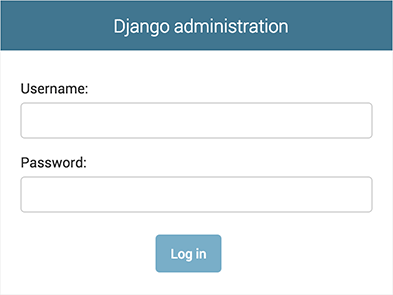

Since translation is turned on by default, if you set LANGUAGE_CODE, the login screen will be displayed in the given language (if Django has appropriate translations).

# **Enter the admin site:**

Now, try logging in with the superuser account you created in the previous step. You should see the Django admin index page:

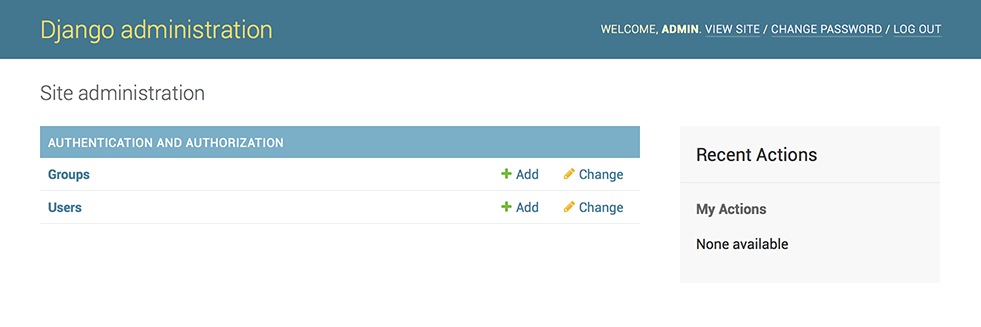

You should see a few types of editable content: groups and users. They are provided by django.contrib.auth, the authentication framework shipped by Django.

# **Make the poll app modifiable in the admin**

But where’s our poll app? It’s not displayed on the admin index page.

Only one more thing to do: we need to tell the admin that Question objects have an admin interface. To do this, open the polls/admin.py file, and edit it to look like this:

In [ ]:
from django.contrib import admin

from .models import Question

admin.site.register(Question)

# **Explore the free admin functionality:**

Now that we’ve registered Question, Django knows that it should be displayed on the admin index page:

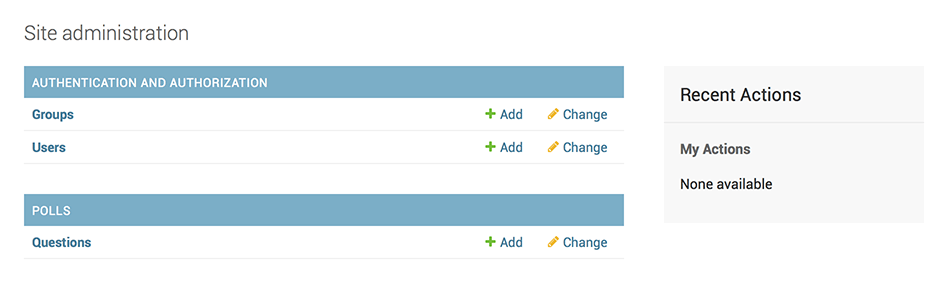

Click “Questions”. Now you’re at the “change list” page for questions. This page displays all the questions in the database and lets you choose one to change it. There’s the “What’s up?” question we created earlier:

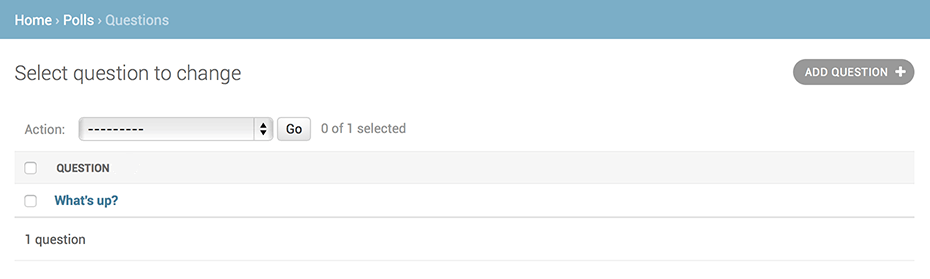

Click the “What’s up?” question to edit it:
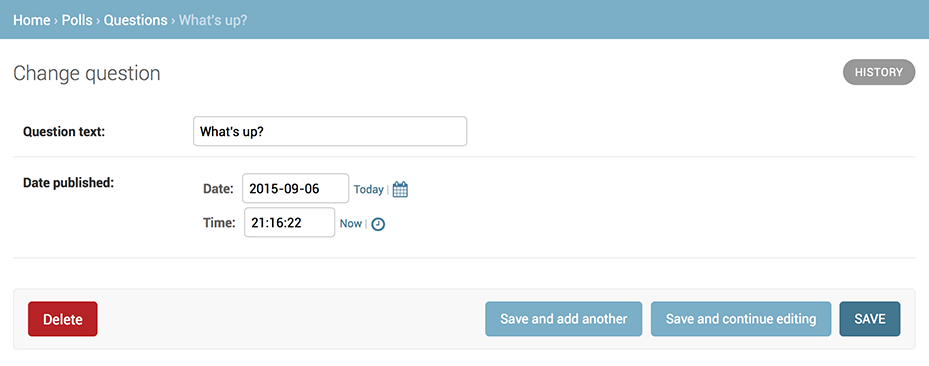

Things to note here:

The form is automatically generated from the Question model.
The different model field types (DateTimeField, CharField) correspond to the appropriate HTML input widget. Each type of field knows how to display itself in the Django admin.
Each DateTimeField gets free JavaScript shortcuts. Dates get a “Today” shortcut and calendar popup, and times get a “Now” shortcut and a convenient popup that lists commonly entered times.
The bottom part of the page gives you a couple of options:

Save – Saves changes and returns to the change-list page for this type of object.
Save and continue editing – Saves changes and reloads the admin page for this object.
Save and add another – Saves changes and loads a new, blank form for this type of object.
Delete – Displays a delete confirmation page.
If the value of “Date published” doesn’t match the time when you created the question in Tutorial 1, it probably means you forgot to set the correct value for the TIME_ZONE setting. Change it, reload the page and check that the correct value appears.

Change the “Date published” by clicking the “Today” and “Now” shortcuts. Then click “Save and continue editing.” Then click “History” in the upper right. You’ll see a page listing all changes made to this object via the Django admin, with the timestamp and username of the person who made the change:

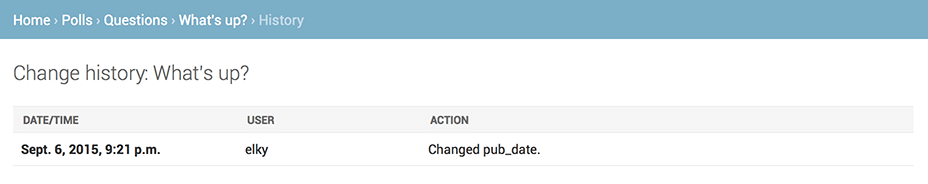

hen you’re comfortable with the models API and have familiarized yourself with the admin site, read part 3 of this tutorial to learn about how to add more views to our polls app.